# Bar chart animation for COVID-19 statistics worldwide

## Load tools and data

This script makes use of the following libraries:
 - pandas and numpy for the data analysis; (currently tested with pandas-vX.X and numpy-vX.X)
 - matplotlib for plotting; (currently tested with matplotlib-vX.X)
 - iso3166 for standardized geographic data of countries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from iso3166 import Country
import flag
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
datacvs = 'owid-covid-data.csv'
# Load useful data from CVS file as pandas dataframe
df = pd.read_csv(datacvs, usecols=['continent','location','date','new_cases_smoothed_per_million','total_deaths','new_deaths','total_deaths_per_million','new_deaths_per_million','new_deaths_smoothed_per_million','reproduction_rate','new_tests','new_tests_per_thousand','tests_per_case'], parse_dates=[2])

# Shorten dataframe to minimal set of columns and pick out single day
dfshort=df[['location','date','total_deaths_per_million']]
df_now = df[df["date"]=='20210106'].sort_values(by="total_deaths_per_million", ascending=False).reset_index(drop=True)

# List locations (countries) and map colours
locations=set(df["location"].to_dict().values())
loclist = list(locations)
loclist.sort()

cols = plt.cm.Pastel1.colors + plt.cm.Pastel2.colors + plt.cm.Paired.colors + plt.cm.Accent.colors + plt.cm.Set1.colors + plt.cm.Set2.colors + plt.cm.Dark2.colors + plt.cm.tab20c.colors + plt.cm.Set3.colors + plt.cm.tab20.colors + plt.cm.tab20b.colors 
color_dict = dict(zip(loclist, [cols[k] for k in np.arange(len(loclist)) % len(cols)]))

## Transitions

Whenever one bar overtakes another, the single-frame transition is difficult for the eye to follow.
The following functions define a smoother transition by storing the current positions and velocities of all bars and updating the next frame based on the target positions.
As a simple motion model, the velocity of a given bar undergoing transition can be constant so that the bar reaches its target position within a predefined amount of time. A possible improvment is to decelerate smoothly by slowing down in the final few frames.
Additional features may include: 
 - a visual indicator for the up or down motion of a bar
 - a z-index giving depth to the overlapping bars (up-going to foreground and v.v.)

In [124]:
# Transition functions

def initData(N=len(loclist)):
    # Initialize bar positions and velocities
    global Y_now, V_now
    Y_now = N - 1.0*np.arange(N)
    V_now = 1.0*np.zeros(N)
    return

def V(delta_y, sec_per_transition=1):
    '''Vertical velocity of bar coordinate as a function of distance to true location'''
    # [TODO: needed in vertical index units per seconds]
    c = 1./sec_per_transition
    v = c*delta_y
#     if (delta_y == 0.0):
#         return 0.0
#     elif (abs(delta_y) < 0.2):
#         v = 0.05*delta_y/abs(delta_y)
#     else: 
#         v = c*delta_y
        
    return v
        
        

def update_positions(y_target):
    ''' Calculates the interpolated coordinate 
     Input:
      - y_target :   array with target coordinate values
      # - y_now    :   the current coordinate value
     Output:
      - global Y_now    :   updates array with the new coordinates
      - global V_now    :   updates array with the new velocities
    '''

    global Y_now, V_now
    
    dt = 1.0/fps
    dy = y_target - Y_now
    V_now = V(dy)
    
    Y_now += V_now*dt
    
    reached = np.where(abs(V_now*dt) > abs(dy))[0]
    if reached.size > 0: 
        Y_now[reached] = y_target[reached]
        
    return
    
    
def data_interp(datelist, df):
    '''Interpolates data for new list of timestamps'''
    
    # Create DataFrame object
    df_interp = pd.DataFrame(columns=['location','date','total_deaths_per_million'])
    
    # group by country
    dfl = df.groupby('location')
    
    # iterate through countries
    for l in dfl.groups.keys():
        dg = dfl.get_group(l)
        x = [k.timestamp() for k in dg['date'].to_list()]
        y = dg['total_deaths_per_million']

        l_interp = np.interp([k.timestamp() for k in datelist.to_list()], x, y)
        l_df = pd.DataFrame({'location':[l]*len(datelist), 'date':datelist, 'total_deaths_per_million':l_interp})
        df_interp = pd.concat([df_interp, l_df])
    
    return df_interp #.groupby('date')

In [107]:
initData()
Y_now

array([192., 191., 190., 189., 188., 187., 186., 185., 184., 183., 182.,
       181., 180., 179., 178., 177., 176., 175., 174., 173., 172., 171.,
       170., 169., 168., 167., 166., 165., 164., 163., 162., 161., 160.,
       159., 158., 157., 156., 155., 154., 153., 152., 151., 150., 149.,
       148., 147., 146., 145., 144., 143., 142., 141., 140., 139., 138.,
       137., 136., 135., 134., 133., 132., 131., 130., 129., 128., 127.,
       126., 125., 124., 123., 122., 121., 120., 119., 118., 117., 116.,
       115., 114., 113., 112., 111., 110., 109., 108., 107., 106., 105.,
       104., 103., 102., 101., 100.,  99.,  98.,  97.,  96.,  95.,  94.,
        93.,  92.,  91.,  90.,  89.,  88.,  87.,  86.,  85.,  84.,  83.,
        82.,  81.,  80.,  79.,  78.,  77.,  76.,  75.,  74.,  73.,  72.,
        71.,  70.,  69.,  68.,  67.,  66.,  65.,  64.,  63.,  62.,  61.,
        60.,  59.,  58.,  57.,  56.,  55.,  54.,  53.,  52.,  51.,  50.,
        49.,  48.,  47.,  46.,  45.,  44.,  43.,  4

In [27]:
dict(zip(loclist, Y_now))

{'Afghanistan': 192,
 'Albania': 191,
 'Algeria': 190,
 'Andorra': 189,
 'Angola': 188,
 'Antigua and Barbuda': 187,
 'Argentina': 186,
 'Armenia': 185,
 'Australia': 184,
 'Austria': 183,
 'Azerbaijan': 182,
 'Bahamas': 181,
 'Bahrain': 180,
 'Bangladesh': 179,
 'Barbados': 178,
 'Belarus': 177,
 'Belgium': 176,
 'Belize': 175,
 'Benin': 174,
 'Bhutan': 173,
 'Bolivia': 172,
 'Bosnia and Herzegovina': 171,
 'Botswana': 170,
 'Brazil': 169,
 'Brunei': 168,
 'Bulgaria': 167,
 'Burkina Faso': 166,
 'Burundi': 165,
 'Cambodia': 164,
 'Cameroon': 163,
 'Canada': 162,
 'Cape Verde': 161,
 'Central African Republic': 160,
 'Chad': 159,
 'Chile': 158,
 'China': 157,
 'Colombia': 156,
 'Comoros': 155,
 'Congo': 154,
 'Costa Rica': 153,
 "Cote d'Ivoire": 152,
 'Croatia': 151,
 'Cuba': 150,
 'Cyprus': 149,
 'Czechia': 148,
 'Democratic Republic of Congo': 147,
 'Denmark': 146,
 'Djibouti': 145,
 'Dominica': 144,
 'Dominican Republic': 143,
 'Ecuador': 142,
 'Egypt': 141,
 'El Salvador': 140,
 'E

<StemContainer object of 3 artists>

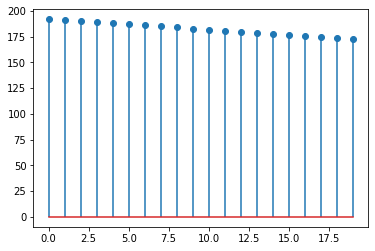

In [5]:
# Test plot for positions

fig_test, ax_test = plt.subplots(figsize=(6, 4))
ax_test.stem(Y_now[:20])

## Set up animation

In [6]:
duration = 3                # animation duration in seconds
sec_per_transition = 1        # how many seconds does a transition last
fps = 24                      # frames per second
nframes = fps*duration        # total number of frames
fpt = fps/sec_per_transition  # frames per transition

focus_country = Country.gr

startdate='08/24/2020'        # start animation from date
enddate='10/01/2020'          # end animation at date

# create array of timestamps by dividing date range with uniform steps
datelist = pd.date_range(start=startdate, end=enddate, periods=nframes)

# interpolate data for datelist
df_interp = data_interp(datelist, dfshort)


In [92]:
# -------- NOT USED !!! ---------

# Extract data for focus country

# Make sure country is in list
assert(focus_country.english_short_name in dfshort['location'].unique())

dffoc = dfshort.groupby('location').get_group(focus_country.english_short_name) #.copy(deep=True)

# Add column with datetime values
dffoc.loc['datetime'] = pd.to_datetime(dffoc['date'])
dffoc.index = dffoc['datetime']

## Draw Barchart

The basic idea for the barchart follows the example by @jburnmurdoch [link].
On top of that, several additions have been made, especially for making the animation smoother (interpolation), adapting to COVID-19 specific data and a few additional features (transitions, focus location, aesthetics, etc.).

In [42]:
da['state'].map(langdict)

0      greek
1    english
2      dutch
Name: state, dtype: object

In [33]:
dd = {'town': ['corfu', 'cambridge', 'utrecht'],
      'state': ['gr', 'en', 'nl'],
      'grade': [10, 8, 9]}
da = pd.DataFrame(dd)
langdict = {'gr':'greek', 'en':'english','nl':'dutch'}
da['lang'] = da['state'].map(langdict)
da

In [86]:
dfg = df_interp.groupby('date').get_group(datelist[30])
dfg = dfg.sort_values(by='total_deaths_per_million', ascending=False).copy(deep=True)
dfg.reset_index(drop=True, inplace=True)
ddict = dfg['location'].to_dict()

In [157]:
def draw_barchart(date, focus=focus_country.english_short_name, nplot=11):
    
    global Y_now, V_now
    
    # Select data on date, add old and new positions and sort
    dff = df_interp.groupby('date').get_group(date)

    dff = dff.sort_values(by='total_deaths_per_million', ascending=False).copy(deep=True)
    dff.reset_index(drop=True, inplace=True)
    target_dict = dict(zip(dff['location'].to_numpy(), np.arange(len(dff))))
    
    # Read off target locations in loclist order and update 
    Y_target = [target_dict[k] for k in loclist]
    update_positions(Y_target)
    
    # add new positions
    y_dict = dict(zip(loclist, Y_now))
    dff['y_new'] = dff['location'].map(y_dict)

    # Select range of indices to plot
    focus_indices = []

    # if no focus country is fiven, plot top N
    if focus not in locations:
        focus = None
        print("No focus!")
        imin = 0
        imaxpp = nplot
    else: 
        focus_index = dff[dff['location']==focus].index.to_numpy()[0]
        focus_indices.append(focus_index)
        imin = np.max([focus_index - (nplot//2),0])
        imaxpp = imin + nplot

#     idx_plot = dff.iloc[list(dff['total_deaths_per_million'] <= bar_num)].iloc[i]
    idx_plot = np.arange(imin,imaxpp)
    dfs = dff.iloc[idx_plot]
    
#     print(focus_indices)
    
    # Plot horizontal bars
    ax.clear()
    y_pos = nplot - np.arange(nplot)
    y_pos = nplot - np.array([y_dict[k] for k in dfs['location'].to_numpy()])


    bars = ax.barh(y_pos, dfs['total_deaths_per_million'], color=[color_dict[k] for k in dfs['location'].to_numpy()], alpha=0.9, tick_label=[str(k) for k in list(dfs.index.to_numpy())])
    # height=10/nplot,
    #     ax.set_yticks(y_pos, labels=list(dfs.index.to_numpy()))
    #     ax.invert_yaxis()
    dx = dfs['total_deaths_per_million'].max() / 200
    
        
    print (y_pos)

    for bar, location in zip(bars, dfs['location']):
#    for i, (value, location) in enumerate(zip(dfs['total_deaths_per_million'], dfs['location'])):
        # ax.text(value-dx, nplot - i-.25, flag.flag("gr"), size=10, color='#444444', ha='right', va='baseline')
        # ax.text(value+dx, nplot - i,     f'{value:,.0f}',  size=14, ha='left',  va='center')

        width = bar.get_width()
        ax.text(width + dx, bar.get_y() + bar.get_height() / 2, location, size=14, weight='light', ha='left', va='center')
        ax.annotate(f'{width:.0F}',
                    xy = (width , bar.get_y() + bar.get_height() / 2),
                    xytext = (-25, 0),
                    textcoords = "offset points",
                    fontsize = 'x-large',
                    fontweight = 'light',
                    ha = 'right',
                    va = 'center')    
        
    ax.text(1, 0.2, date.strftime("%d %B, %Y"), transform=ax.transAxes, color='#AAAAAA', size=24, ha='right', weight=800)
    ax.text(0, 1.06, 'Deaths per million (total)', transform=ax.transAxes, size=12, color='#AAAAAA')
    
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', color='#777777', labelsize=12)
#     ax.tick_params(labelsize = 'medium')    
#     ax.set_yticks([str(k) for k in list(dfs.index.to_numpy())])
    ax.grid(True, axis = 'x')
    if focus:
        ax.set_xlim(0, 2.0*dff.iloc[focus_index]['total_deaths_per_million'])
        ax.set_ylim()
    
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    
    ax.set_axisbelow(True)
    
    ax.text(0, 1.15, 'World ranking in COVID-19 deaths per million population', transform=ax.transAxes, size=24, weight=600, ha='left', va='top')
    ax.text(1, 0, '@magathos', transform=ax.transAxes, color='#777777', ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    plt.box(False)
    
def update_plot(date, focus=focus_country.english_short_name, nplot=None):
    
    update_positions(date)
    update_velocities(date)
    draw_barchart(date, focus, nplot)
    return

[-69. -70. -71. -72. -73. -74. -75. -76. -77. -78. -79. -80. -81. -82.
 -83. -84. -85. -86. -87. -88.]


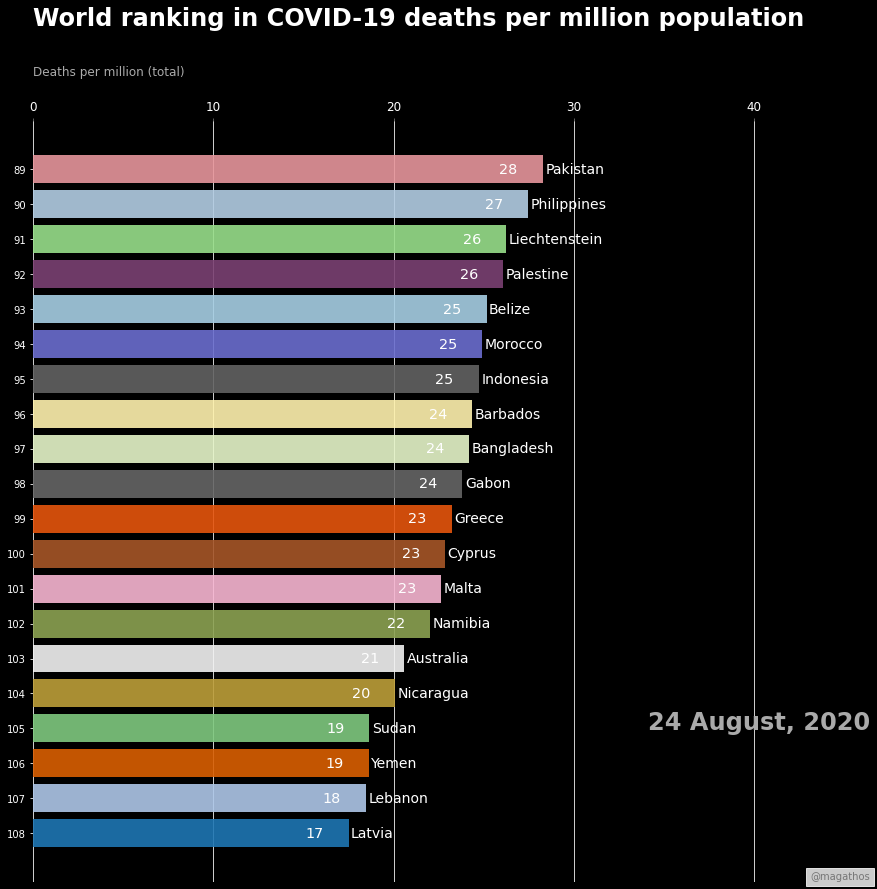

In [158]:
#plt.style.available
plt.style.use('dark_background')

# initData()
sdf = df_interp.groupby('date').get_group(datelist[0]).sort_values(by='total_deaths_per_million', ascending=False).reset_index(drop=True)
target_dict = dict(zip(sdf['location'].to_numpy(), np.arange(len(sdf))))

# Read off target locations in loclist order and update 
Y_now = np.array([1.0*target_dict[k] for k in loclist])

fig, ax = plt.subplots(figsize=(15, 14))
draw_barchart(datelist[0], focus=focus_country.english_short_name, nplot=20)

## Animate

To animate, we will use [`FuncAnimation`][FuncAnimation] from `matplotlib.animation`.

[`FuncAnimation`][FuncAnimation] makes an animation by repeatedly calling a function (that draws on canvas). 
In our case, it'll be `draw_barchart`.

`frames` arguments accepts on what values you want to run `draw_barchart`.

Run cell below.

[FuncAnimation]: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.animation.FuncAnimation.html

In [153]:
tslist = np.linspace(datelist[-1].timestamp(), datelist[0].timestamp(), num=nframes).astype(int)

In [154]:
pd.to_datetime(tslist[0])

Timestamp('1970-01-01 00:00:01.585699200')

[-83. -84. -85. -86. -87. -88. -89. -90. -91. -92. -93.]
[-83. -84. -85. -86. -87. -88. -89. -90. -91. -92. -93.]
[-82.04166667 -84.         -85.         -86.         -87.
 -88.         -89.         -90.         -91.         -92.
 -93.        ]
[-82.08159722 -84.         -85.95833333 -85.04166667 -87.
 -88.         -89.         -90.         -91.         -92.
 -93.        ]
[-80.125      -84.         -85.91840278 -85.08159722 -87.
 -88.         -90.91666667 -89.04166667 -90.04166667 -92.
 -93.        ]
[-82.84346366 -80.24479167 -84.         -85.880136   -85.119864
 -87.95833333 -87.04166667 -90.83680556 -89.08159722 -90.08159722
 -92.        ]
[-82.80831934 -80.35959201 -84.         -85.84346366 -85.15653634
 -87.91840278 -87.08159722 -90.76027199 -89.119864   -91.95833333
 -90.16153067]
[-81.         -82.77463937 -80.46960901 -84.         -85.80831934
 -87.83846933 -85.23334732 -90.64526066 -87.16153067 -91.87673611
 -89.198203  ]
[-82.74236273 -80.57504197 -84.         -85.77463937 -

[-73.95483415 -76.60182913 -76.58827407 -82.56822163 -78.73653878
 -85.91083861 -84.34112679 -81.7046488  -83.25830029 -87.3381804
 -85.14767634]
[-71.94612471 -74.12338272 -76.70175292 -76.73042932 -82.50287906
 -85.74788701 -78.914183   -84.32691317 -81.8419551  -87.28242288
 -83.41420444]
[-72.15670285 -74.28490844 -76.79751321 -76.86666143 -82.4402591
 -85.59172505 -79.08442537 -84.31329179 -81.9735403  -87.22898859
 -83.56361259]
[-74.43970392 -82.31119547 -76.93095016 -77.03888387 -82.42191497
 -85.4837365  -79.28924098 -84.34190463 -82.14130946 -87.2194474
 -83.74846207]
[-72.59356911 -74.62971626 -77.05882724 -82.36266852 -77.24559704
 -85.38024748 -79.48552261 -84.36932527 -82.30208823 -87.21030376
 -83.92560948]
[-72.81883706 -74.81181142 -77.1813761  -82.30589066 -77.44369716
 -85.2810705  -79.67362583 -84.39560338 -82.45616789 -87.2015411
 -84.09537575]
[-73.03471885 -74.98631927 -77.29881877 -82.25147855 -77.63354312
 -85.1860259  -79.85389142 -84.42078658 -82.60382756 -87

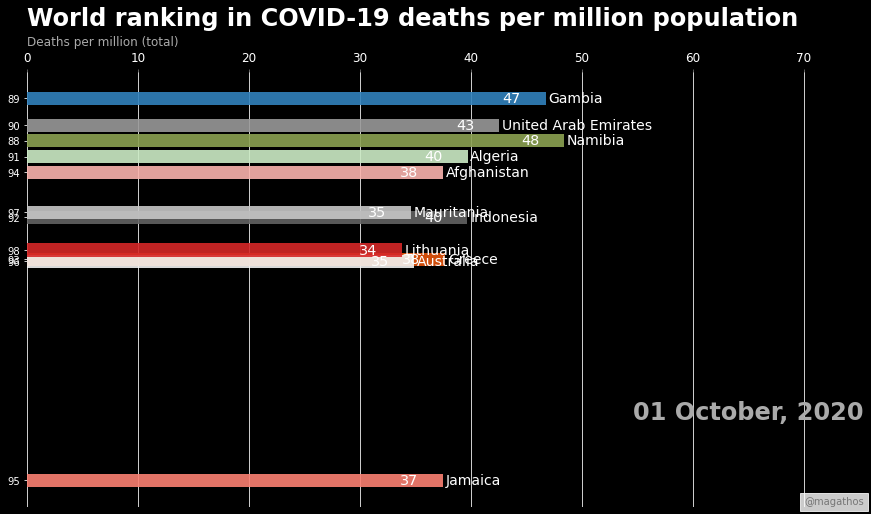

In [159]:
fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, draw_barchart, frames=datelist, interval=1000./fps)
HTML(animator.to_jshtml())
# or use animator.to_html5_video() or animator.save() 